# $k$-means Clustering

## Introduction

$k$-means clustering is a classical problem in data science. It consists in finding a partition of a given set of observations into a given number of clusters.

![Example](data.png "Before k_means")

<div style="text-align: center;">
    <img src="arrow.png" alt="Arrow" style="width: 100px; height: auto; margin-left: -150px;">
</div>

![Example](clusterdata.png "After k_means")


## Notebook installation requirements 

In [1]:
import subprocess
import sys

def install_requirements():
    try:
        with open('requirements.txt') as f:
            packages = f.read().splitlines()
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-r', 'requirements.txt'])
        print("All packages have been successfully installed.")
    except Exception as e:
        print(f"An error occurred while installing the packages: {e}")

install_requirements()

All packages have been successfully installed.


## Problem description

**Inputs**
* $N$ observations with their coordinates $X_i$, $i = 1, \dots, N$ in the considered space
* A number of clusters to build $K$.

**Problem**: partition the $N$ observations into $K$ clusters such that each observations belongs to exactly one cluster.

**Objective**: minimize the total sum of euclidean distances between each observation and the center of its cluster

$$
\min \sum_{k=1}^K \sum_{i \in \mathrm{cluster_k}} \| X_i - c_k \|^2_2
$$
with $c_k$ the coordinates of the center of cluster $k$.

## Resolution with Scikit-learn

$k$-means clustering being a classical problem in data science, algorithms to solve it are already available. For example, in Python, Scikit-learn offers an algorithm to solve $k$-means clustering problems.

First, let's generate some data:

In [2]:
import pandas as pd 
import numpy as np

data = pd.read_csv('kmeans.csv')
print(data)

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

             X          Y
0     2.072345  -3.241693
1    17.936710  15.784810
2     1.083576   7.319176
3    11.120670  14.406780
4    23.711550   2.557729
..         ...        ...
295  12.731310   7.050802
296   8.388222  23.453470
297  23.427080   4.598641
298   4.046104   7.634936
299   7.667025   3.193633

[300 rows x 2 columns]


In [3]:
X = data['X'].values
Y = data['Y'].values 
observations_positions = np.array(list(zip(X,Y)))
nb_observations = len(observations_positions)
nb_clusters = 3

Let's plot this data:

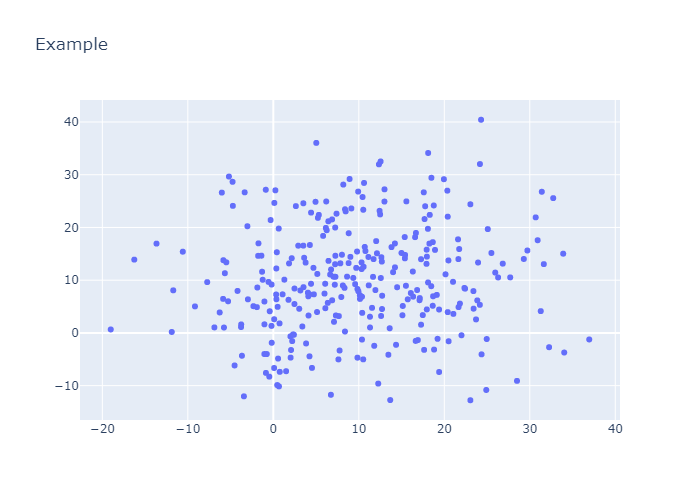

In [4]:
import plotly.graph_objects as go

def draw_data(observations_positions,name):
    nb_observations = len(observations_positions)
    fig = go.Figure()
    fig.add_scatter(x = [observations_positions[i][0] for i in range(nb_observations)], y =  [observations_positions[i][1] for i in range(nb_observations)], mode ='markers', name="Observations")
    fig.update_layout(
        title = name,
                )
    fig.show("png")

draw_data(observations_positions, "Example")

Now, let's, solve the problem using the algorithm from Scikit-learn:

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(observations_positions)

Let's visualize the solution:

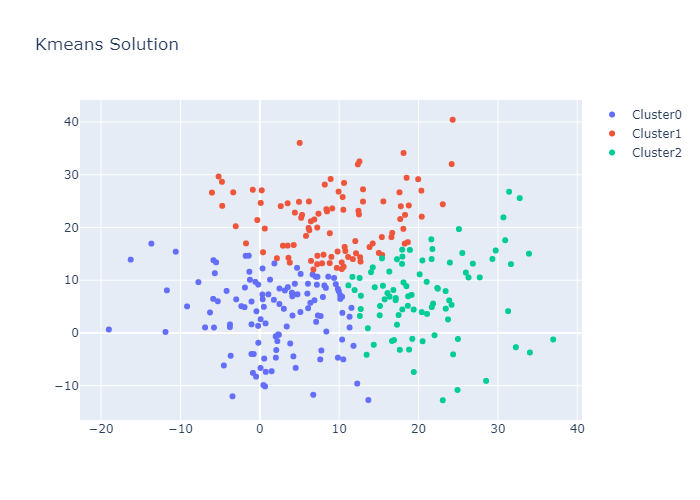

Total cost (which is the total sum of euclidean distances between each observation and the center of its cluster): 26236.67493465098


In [6]:
fig_sk = go.Figure()
for j in range(nb_clusters):
    fig_sk.add_scatter(x = [observations_positions[i][0] for i in range(nb_observations) if (kmeans.labels_[i] == j)], y =  [observations_positions[i][1] for i in range(nb_observations) if (kmeans.labels_[i] == j)], mode ='markers', name=f"Cluster{j}")

fig_sk.update_layout(
        title = "Kmeans Solution",
                )

fig_sk.show("png")
print(f"Total cost (which is the total sum of euclidean distances between each observation and the center of its cluster): {kmeans.inertia_}")

## Mathematical model
Now, we show how to model the $k$-means clustering problem using nonlinear programming.

Variables:

* $a^k_i \in \{ 0 , 1\}$,  $i = 1, \dots, N$, $k = 1, \dots, K$: a boolean variable which is 1 if the observation $i$ is in cluster $k$: else 0 .
* $d^k_i \in \mathbb{R^+}$, $i = 1, \dots, N$, $k = 1, \dots, K$: a positive variable which represents the euclidian squared distance between observation i and cluster k.
* $c^k \in \mathbb{R^2}$,  $k = 1, \dots, K$: position of the barycenter of the cluster k. 

Objective:
$$
\min \sum_{i=1}^N{\sum_{k=1}^K}{a^k_id^k_i}
$$

Constraints:
* Each observation has to be in one cluster
$$
\forall i = 1, \dots, N \qquad\sum_{k=1}^K{a^k_i}= 1
$$

* Coordinates of the barycenter of the clusters
$$
\forall k = 1, \dots, K \qquad c_k\sum_{i=1}^N{a^k_i} = \sum_{i=1}^N{X_i}a^k_i 
$$

* Square distance formula
$$
\forall i = 1, \dots, N, \forall k = 1, \dots, K, \qquad d^k_i = \| X_i - c_k \|^2_2
$$

# Implementation with Pyomo

Now, let's write the model with the modeler Pyomo.


In [7]:
import pyomo.environ as pyo

def build_model(nb_observations, nb_clusters):

    ####################
    # Create variables #
    ####################
    
    model.N = pyo.RangeSet(0, nb_observations - 1)
    model.K = pyo.RangeSet(0, nb_clusters - 1)
    model.a = pyo.Var(model.N, model.K, within = pyo.Binary)
    model.d = pyo.Var(model.N, model.K, within = pyo.NonNegativeReals)
    # cx & cy (abcissa and ordinate)
    model.cx = pyo.Var(model.K, within = pyo.Reals)
    model.cy = pyo.Var(model.K, within = pyo.Reals)
    
    #############
    # Objective #
    #############
    
    model.objective = pyo.Objective(
                expr= pyo.quicksum(model.a[s,t]* model.d[s,t]
                                   for s in model.N
                                   for t in model.K),
                sense=pyo.minimize)
    
    ###############
    # Constraints #
    ###############
    
    
    def one_cluster_rule(model,i):
        total = 0
        for j in range(nb_clusters):
            total += model.a[i,j]
        return (total == 1)
    model.constraints_one_cluster = pyo.Constraint(model.N, rule=one_cluster_rule)
    
    def barycenter_x_position_rule(model, j):
        total_a = 0 
        total_pa_x = 0
        for i in range(nb_observations):
             total_a += model.a[i,j]
             total_pa_x += model.a[i,j] * observations_positions[i][0]
        return (model.cx[j] * total_a == total_pa_x)
    model.constraints_barycenter_x_position_rule = pyo.Constraint(model.K,rule=barycenter_x_position_rule)
    
    def barycenter_y_position_rule(model, j):
        total_a = 0 
        total_pa_y = 0
        for i in range(nb_observations):
             total_a += model.a[i,j]
             total_pa_y += model.a[i,j] * observations_positions[i][1]
        return (total_a * model.cy[j] == total_pa_y)
    model.constraints_barycenter_y_position_rule = pyo.Constraint(model.K,rule=barycenter_y_position_rule)

    def dist_rule(model,s,t):
        return (model.d[s,t] == (((observations_positions[s][0]-model.cx[t])**2)  +
                                                         ((observations_positions[s][1]-model.cy[t])**2)))

    model.constraints_dist_rule = pyo.Constraint(model.N,model.K,rule=dist_rule)

# Let's build the model and run it 
model = pyo.ConcreteModel()
build_model(nb_observations,nb_clusters)
solver = pyo.SolverFactory('knitroampl')
results = solver.solve(model, tee=True)

Artelys Knitro 14.1.0: 
          Commercial License
         Artelys Knitro 14.1.0

No start point provided -- Knitro computing one.

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_

   72        42308.1      5.15268e-03           66.8564       1.708
   73        42281.0      2.85893e-03           66.8602       1.736
   74        42216.0      5.82716e-02           66.8672       1.758
   75        42186.6      1.23702e-02           69.4217       1.778
   76        42117.4      6.39415e-02           74.7473       1.808
   77        42102.6      3.01014e-03           74.7487       1.831
   78        42082.7      4.20294e-03           74.7352       1.853
   79        41966.7         0.106213           77.8061       1.872
   80        41909.7      2.09260e-02           38.0348       1.891
   81        41844.5      2.84104e-02           19.8907       1.910
   82        41842.3      2.84037e-02           20.5224       1.933
   83        41821.4      8.34499e-03           28.5178       1.960
   84        41736.3      5.99638e-02           55.1520       1.974
   85        41658.7      9.02260e-02           75.8501       1.987
   86        41616.7      1.43234e-02           

  202        36250.5      4.91984e-02           18.8379       4.755
  203        36154.3         0.137069           24.6958       4.769
  204        36102.1         0.142825           25.4574       4.784
  205        36006.1         0.223825           30.4542       4.796
  206        36000.6      6.16379e-04           9.43916       4.814
  207        35991.2      2.42597e-03           9.73727       4.824
  208        35966.2      5.58148e-03           11.5607       4.839
  209        35843.9      5.51052e-02           26.8087       4.860
  210        35740.3      2.43877e-02           38.9111       4.878
  211        35573.4      7.79036e-02           23.3486       4.892
  212        35506.3      9.24492e-02           12.4898       4.901
  213        35511.5      8.36733e-02           10.6179       4.921
  214        35481.3      8.44871e-02           10.2502       4.942
  215        35464.0      2.55938e-03           6.03578       4.958
  216        35431.7      9.53404e-03           

  329        27293.2      4.00342e-02           39.9067       7.370
  330        27280.9      2.12192e-04           40.8199       7.391
  331        27255.8      1.88208e-03           41.6686       7.420
  332        27198.1      5.76435e-02           34.5775       7.432
  333        27175.7         0.104525           34.6551       7.441
  334        27154.0         0.247583           36.2329       7.456
  335        27111.4         0.385519           30.1540       7.469
  336        27093.0         0.311454           26.6558       7.499
  337        27061.3         0.285492           32.1937       7.512
  338        27061.0         0.235199           31.7516       7.526
  339        27023.6         0.200182           27.4785       7.538
  340        26996.0         0.194666           24.2706       7.567
  341        26984.8         0.174783           19.2917       7.590
  342        26921.6         0.159100           15.1068       7.606
  343        26920.4         0.117677           



# Comparison with Scikit-learn

Let's visualize the solution and compare it with the classic Kmeans Algorithm.

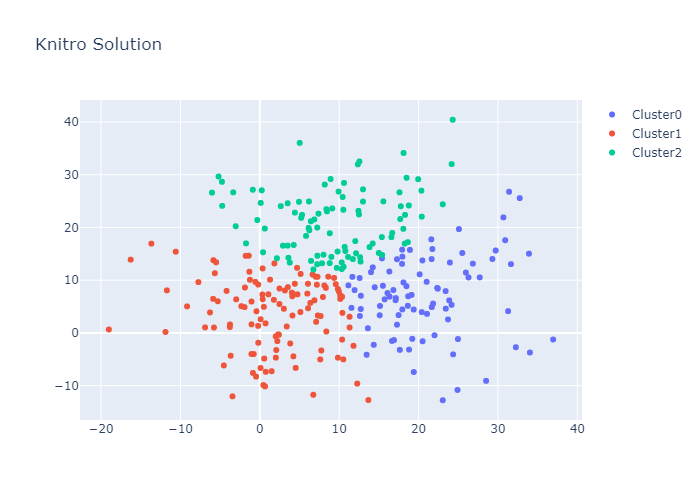

Cluster 0 contains 88 observations
Cluster 1 contains 117 observations
Cluster 2 contains 95 observations
Total cost is 26235.011222344914


In [8]:
def draw_figure(nb_observations,nb_clusters,model,name):
    fig = go.Figure()
    for k in range(nb_clusters):
        fig.add_scatter(x = [observations_positions[i][0] for i in range(nb_observations) if (model.a[i,k]() > 0.99)], y =  [observations_positions[i][1] for i in range(nb_observations) if (model.a[i,k]() > 0.99)], mode ='markers', name=f"Cluster{k}")
    fig.update_layout(
        title = name,
                )
    fig.show("png")
    
    for k in range(nb_clusters):
        total = 0
        for i in range(nb_observations):
            if (model.a[i,k]() > 0.99):
                total += 1
        print(f"Cluster {k} contains {total} observations") 
    
    print(f"Total cost is {model.objective()}")

draw_figure(nb_observations,nb_clusters,model, "Knitro Solution")

Nonlinear programming is significantly slower than the algorithm implemented in Sciki-learn. However, it finds a better solution ($26235.01 < 26243.6$) on the considered instance.

In the next section, we will see that another advantage of nonlinear programming is when additional constraints need to be taken into account.

# Model Extensions

In some cases, additional constraints must be taken into account. These extensions are usually not supported by the algorithms available in the data science libraries. Here we illustrate 3 of these additional constraints and how to model them with nonlinear programming:
* Force some pairs of observations to be in the same cluster
* Force some pairs of observations to be in different clusters
* Impose a minimum and maximum sizes for clusters

## Cannot-link and must-link observations

### Problem description

In some cases, some pairs of observations might be known to belong to the same cluster or to different clusters. These are called "must-link" and "cannot-link" constraints.

Let $P^\text{must}$ be the set of set of observations that must belong to the same cluster.

Let $P^\text{cannot}$ be the set of pairs of observations that must belong to different clusters.

### Input data

The input data of observations is the same as for the previous example. We just need to specify must-link observations or cannot-link observations (between two observations which should not be linked)

#### Must-link observations

In [9]:
must_link_g1 = []
must_link_g2 = []
cannot_link = []

for k in range(nb_observations):
    if(0 < observations_positions[k][0] < 10 and observations_positions[k][1] >= 20):
        must_link_g1.append(k)
    if (10 < observations_positions[k][0] < 20 and observations_positions[k][1] >= 20):
        must_link_g2.append(k)
    if( observations_positions[k][0] == 8.9204 or observations_positions[k][0] == 10.61132):
        cannot_link.append(k)
print(cannot_link)

[22, 247]


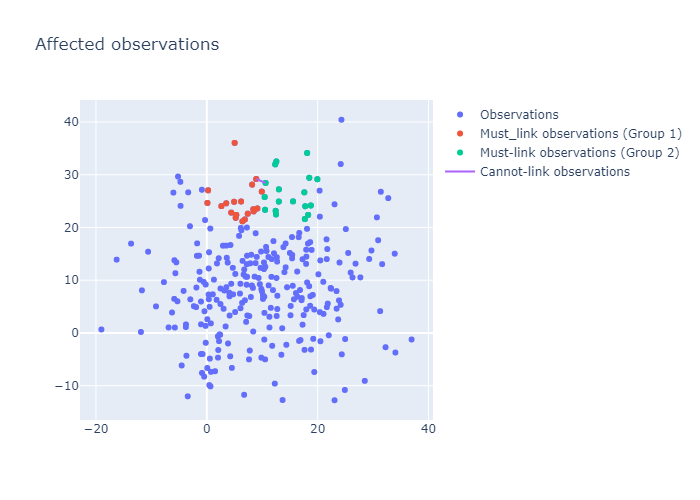

In [10]:
fig = go.Figure()
fig.add_scatter(x = [observations_positions[i][0] for i in range(nb_observations)], y =  [observations_positions[i][1] for i in range(nb_observations)], mode ='markers', name="Observations")
fig.add_scatter(x = [observations_positions[i][0] for i in must_link_g1], y =  [observations_positions[i][1] for i in must_link_g1], mode ='markers', name="Must_link observations (Group 1)")
fig.add_scatter(x = [observations_positions[i][0] for i in must_link_g2], y =  [observations_positions[i][1] for i in must_link_g2], mode ='markers', name="Must-link observations (Group 2)")
fig.add_scatter(x = [observations_positions[i][0] for i in cannot_link], y =  [observations_positions[i][1] for i in cannot_link], mode ='lines', name="Cannot-link observations")
fig.update_layout(
    title = "Affected observations",
            )
fig.show("png")

All red/green elements should be in the same cluster. Moreover, the linked observations should not be in the same cluster.

### Mathematical model

We add the two following set of constraints to the previous mathematical model.

* Must-link constraints

$$
\forall k = 1, \dots, K, \quad \forall S \in P^\text{must}, \quad \forall i \in S, \qquad a^k_{i} = a^k_{S[0]} 
$$

* Cannot-link constraints

$$
\forall k = 1, \dots, K, \quad \forall i_1, i_2 \in P^\text{cannot}, \qquad a^k_{i_1} + a^k_{i_2} \leq 1
$$

### Implementation with Pyomo

In [11]:
model.MLG1 = pyo.Set(initialize = must_link_g1)
model.MLG2 =pyo.Set(initialize = must_link_g2)
model.CL = pyo.Set(initialize = cannot_link)

def cannot_link_rule(model,i,p,j):
    if (i != p):
        return(model.a[i,j] + model.a[p,j] <= 1)
    else:
        return(model.a[i,j] == model.a[p,j])
model.constraints_cannot_link = pyo.Constraint(model.CL,model.CL,model.K,rule=cannot_link_rule)

def must_link_rule_g1(model,i,j):
    return(model.a[i,j] == model.a[must_link_g1[0],j])
model.constraints_must_link_g1 = pyo.Constraint(model.MLG1,model.K,rule=must_link_rule_g1)

def must_link_rule_g2(model,i,j):
    return(model.a[i,j] == model.a[must_link_g2[0],j])
model.constraints_must_link_g2 = pyo.Constraint(model.MLG2,model.K,rule=must_link_rule_g2)

    
#Run with new constraints 
solver = pyo.SolverFactory('knitroampl')
results = solver.solve(model, tee=True)

Artelys Knitro 14.1.0: WARNING: 12 constraints are constant or undefined and will be ignored.

          Commercial License
         Artelys Knitro 14.1.0

MINLP solver shifted start point to satisfy bounds (157 variables).
         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_kna

   67        29286.1      2.67501e-09       5.71801e-02       1.232
   68        29286.1      7.03882e-11       5.71801e-02       1.266
   69        29286.1      3.37764e-10       3.82668e-07       1.274
   70        29286.1      3.37764e-10       3.82668e-07       1.297
   71        29286.1      3.37764e-10       3.82668e-07       1.339

Tree search
-----------

       Nodes        Best solution   Best bound      Gap       Time 
   Expl  |  Unexpl      value         value                  (secs)
   ---------------  -------------   ----------      ---      ------
      1       2      29286.1 FCRD         -inf                1.473
      3       0      29286.1           29286.1     -0.00%     1.600

EXIT: Optimal solution found (assuming convexity).

HINT: The problem may be a non-convex mixed-integer problem.  Set
      mip_multistart=1 to enable a mixed-integer multistart heuristic,
      which may improve the chances of finding the global solution.

Final Statistics for MIP
----------

### Output visualization

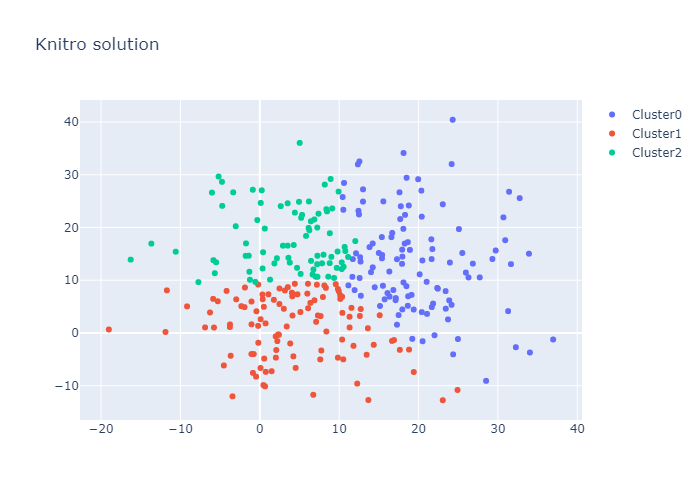

Cluster 0 contains 111 observations
Cluster 1 contains 109 observations
Cluster 2 contains 80 observations
Total cost is 29286.08091910009


In [12]:
draw_figure(nb_observations,nb_clusters,model, "Knitro solution")

## Constrained clustering

### Problem description

Another common case in clustering is to have lower and/or upper bounds on the cluster sizes. This is known as "constrained clustering".

Let $u_{limit} \in \mathbb{R^+}$ be the maximum number of observations in a cluster.

Let $l_{limit} \in \mathbb{R^+}$ be the minimum number of observations in a cluster.

### Input data
To illustrate this, we are going to use some new observations from the `kmeans2.csv` file.
We look to partition these observations into 10 clusters such that the size of each cluster lies between 8 and 12. 

In [13]:
data = pd.read_csv('kmeans2.csv')
print(data)

            X          Y
0    2.072345  -3.241693
1   17.936710  15.784810
2    1.083576   7.319176
3   11.120670  14.406780
4   23.711550   2.557729
..        ...        ...
85   5.987025   7.456533
86  12.639020  14.350810
87   7.392535  22.613040
88  10.372120  -1.258270
89 -19.017910   0.650730

[90 rows x 2 columns]


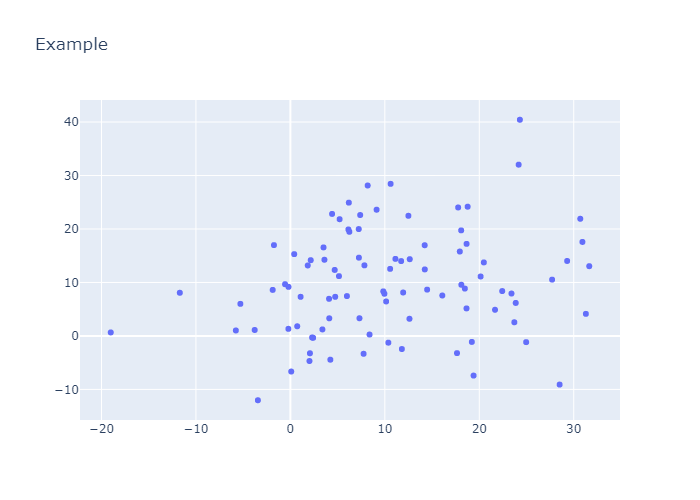

In [14]:
X = data['X'].values
Y = data['Y'].values 
observations_positions = np.array(list(zip(X,Y)))
nb_observations = len(observations_positions)
nb_clusters = 10
draw_data(observations_positions, "Example")

### Resolution without bounds on cluster sizes

Let's solve the problem using the model defined in the previous section. 

In [15]:
model = pyo.ConcreteModel()
build_model(nb_observations,nb_clusters)
solver = pyo.SolverFactory('knitroampl')
results = solver.solve(model, tee=True)

Artelys Knitro 14.1.0: 
          Commercial License
         Artelys Knitro 14.1.0

No start point provided -- Knitro computing one.

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_

   70        11397.5      6.26694e-03           19.9887       1.966
   71        11381.2      4.42987e-03           19.9892       1.989
   72        11360.8      5.20498e-03           22.6700       2.013
   73        11348.6      1.86841e-03           25.0612       2.034
   74        11336.4      5.92938e-03           25.2675       2.064
   75        11304.6      4.32419e-02           32.1321       2.101
   76        11281.2      2.87446e-02           41.4445       2.126
   77        11244.5      6.21144e-02           55.1569       2.151
   78        11227.2      3.94910e-03           56.2608       2.167
   79        11225.2      4.01805e-03           50.9597       2.196
   80        11140.1      8.79540e-02           55.0379       2.211
   81        11119.0      4.55821e-02           55.7404       2.230
   82        11118.5      1.34220e-02           55.9759       2.266
   83        11117.0      4.28332e-03           56.1908       2.286
   84        11098.6      3.83726e-02           

  198        8468.91         0.179778           20.6151       5.226
  199        8471.05      1.34727e-04           21.1623       5.255
  200        8442.81      7.68367e-03           23.1447       5.282
  201        8193.70         0.435082           38.4497       5.304
  202        8134.05      3.39424e-02           26.5251       5.328
  203        8100.75      7.25874e-03           24.9267       5.355
  204        8085.31      1.26062e-03           24.1893       5.376
  205        7993.69      6.24085e-02           20.1974       5.394
  206        7866.89      9.78713e-02           28.6568       5.412
  207        7828.76      8.67174e-03           33.1280       5.431
  208        7754.67      3.23255e-02           34.3197       5.447
  209        7722.87      4.21594e-02           33.3427       5.457
  210        7649.47      6.71864e-02           39.4089       5.479
  211        7519.35         0.102346           36.2029       5.499
  212        7538.40         0.103964           

  322        4973.18      1.92967e-04           7.40674       7.646
  323        4964.07      3.20782e-02           8.38636       7.660
  324        4956.03      5.12572e-02           7.79627       7.674
  325        4951.81      6.26497e-02           7.44406       7.687
  326        4950.55      5.95351e-02           6.64789       7.704
  327        4948.12      5.99851e-02           6.11614       7.720
  328        4942.23      4.75692e-02           4.57029       7.742
  329        4935.60      5.31999e-02           3.76533       7.758
  330        4930.61      4.09122e-03           2.17877       7.784
  331        4926.10      4.77522e-03           2.93529       7.806
  332        4916.43      4.34108e-02           3.43402       7.821
  333        4912.57      4.14484e-02           2.78277       7.842
  334        4906.26      5.10266e-02           1.89133       7.859
  335        4903.11      1.69373e-03           1.95383       7.878
  336        4898.77      2.53155e-03           

  443        3942.36      9.85628e-02           7.03173      10.036
  444        3938.22      8.60847e-02           4.97706      10.064
  445        3853.96         0.362296           12.2012      10.082
  446        3846.06         0.274424           10.9624      10.097
  447        3840.50         0.251939           9.05621      10.112
  448        3835.29         0.245793           8.98439      10.135
  449        3832.05         0.217552           8.35985      10.169
  450        3823.93         0.195298           7.88557      10.212
  451        3817.86         0.151057           8.09761      10.237
  452        3781.45         0.237012           12.4546      10.249
  453        3780.03         0.228823           8.44491      10.276
  454        3770.30         0.213298           8.11634      10.294
  455        3743.16      9.38231e-02           13.0429      10.317
  456        3722.70      6.75858e-02           11.2889      10.337
  457        3721.74      6.39022e-02           

  566        2849.57      2.38948e-02           8.74892      12.884
  567        2836.31      8.85068e-02           9.67932      12.915
  568        2823.44      5.05111e-02           5.41154      12.939
  569        2820.39      5.09183e-02           5.62313      12.956
  570        2814.26      7.91706e-03           6.97197      12.989
  571        2803.86      2.51283e-02           3.53592      13.012
  572        2799.72      2.39008e-02           3.34088      13.029
  573        2792.42      1.79283e-02           2.82522      13.056
  574        2790.99      1.76080e-02           2.35273      13.070
  575        2789.15      3.18059e-03           2.11872      13.093
  576        2788.75      3.26752e-03           2.07434      13.125
  577        2773.34         0.152716           8.52316      13.145
  578        2774.30         0.151488           5.94244      13.178
  579        2762.26      9.81306e-02           1.85258      13.211
  580        2754.64      9.78885e-02           

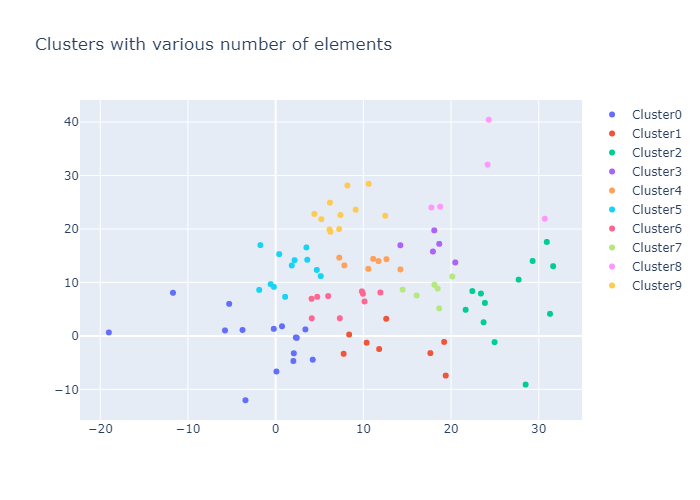

Cluster 0 contains 15 observations
Cluster 1 contains 8 observations
Cluster 2 contains 12 observations
Cluster 3 contains 5 observations
Cluster 4 contains 7 observations
Cluster 5 contains 12 observations
Cluster 6 contains 9 observations
Cluster 7 contains 6 observations
Cluster 8 contains 5 observations
Cluster 9 contains 11 observations
Total cost is 2748.983097227423


In [16]:
draw_figure(nb_observations,nb_clusters,model, "Clusters with various number of elements")

In this case, some clusters have less observations (or more observations) than required. We need to add new constraints to the model in order to take into account the limits on the number of observations in each cluster.

### Mathematical formulation

We add the two following set of constraints to the previous mathematical model.

* Cluster size upper bound

$$
\forall k = 1, \dots, K, \qquad \sum_{i=1}^N {a^k_i} \leq u_{limit}
$$

* Cluster size lower bound

$$
\forall k = 1, \dots, K, \qquad \sum_{i=1}^N {a^k_i} \geq l_{limit}
$$

### Implementation with Pyomo

In [17]:
def size_upper_clusters_rule(model,j):
    total = sum(model.a[i,j] for i in range(nb_observations))
    return (total <= 12)
model.constraints_size_upper_clusters = pyo.Constraint(model.K,rule=size_upper_clusters_rule)

def size_lower_clusters_rule(model,j):
    total = sum(model.a[i,j] for i in range(nb_observations))
    return (total >= 8)
model.constraints_size_lower_clusters = pyo.Constraint(model.K,rule=size_lower_clusters_rule)

results = solver.solve(model, tee=True)

Artelys Knitro 14.1.0: 
          Commercial License
         Artelys Knitro 14.1.0

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing mip_cut_

   69        3143.17      1.97046e-02          0.197977       2.802
   70        3125.90      1.49504e-02          0.204929       2.845
   71        3123.35      1.47054e-02          0.215685       2.895
   72        3087.87      2.06704e-02          0.179008       2.940
   73        3084.04      2.07386e-02          0.164460       2.967
   74        3079.91      1.67127e-02          0.150466       3.009
   75        3080.95      6.19903e-03          0.148613       3.065
   76        3074.09      6.89759e-03          0.158361       3.101
   77        3066.05      9.69863e-03          0.167435       3.144
   78        3060.56      1.13810e-02          0.204393       3.187
   79        3048.16      1.20553e-02          0.186139       3.239
   80        3036.95      1.59141e-02          0.166813       3.287
   81        3014.60      1.74148e-02       6.87101e-02       3.336
   82        3009.97      1.64190e-02       4.75957e-02       3.366
   83        3001.95      1.38726e-02       3.62

### Output visualization

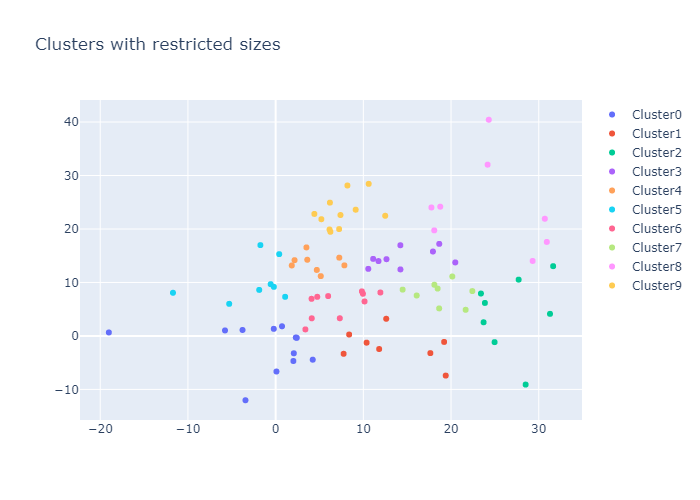

Cluster 0 contains 12 observations
Cluster 1 contains 8 observations
Cluster 2 contains 8 observations
Cluster 3 contains 9 observations
Cluster 4 contains 8 observations
Cluster 5 contains 8 observations
Cluster 6 contains 10 observations
Cluster 7 contains 8 observations
Cluster 8 contains 8 observations
Cluster 9 contains 11 observations
Total cost is 2774.6572562519264


In [18]:
draw_figure(nb_observations,nb_clusters,model,"Clusters with restricted sizes")

The constraints are satisfied, we can observe that each cluster has a number of observations between 8 and 12. 